In [34]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.offline as po
import seaborn as sns
import matplotlib.pyplot as plt 
import os 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing

This notebook contains exploration of all the raw data and will conclude with proposals for data transformations and wrangling.

In [35]:
df = pd.read_csv('_raw/case1Data.txt')

In [36]:
# NA values are by default strings, since there is a space in front
df = df.replace(' NaN', np.nan)

# ensure numeric dtype

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass


In [37]:
# only 4 out of 100 cols are complete.
# the rest contain NA's and require a decision on how to handle it
df.loc[:,df.isna().sum(axis=0) == 0].columns

Index(['y', ' C_ 2', ' C_ 3', ' C_ 4', ' C_ 5'], dtype='object')

In [38]:
# isolate targets from the design matrix
y = df['y']
X = df.iloc[:,1::]


In [39]:
# for convenience, fix the column naming
# with no spaces

X.columns = [name.replace(' ', '') for name in X.columns]
X.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,NaN,NaN,-3.978178,-1.504027,-14.986790,0.651581,-37.878245,16.213807,-3.965437,NaN,...,-7.032047,6.319109,NaN,26.197445,-9.913837,H,H,I,K,J
1,26.204958,11.185962,-8.247602,-3.875866,-11.329702,2.637900,-39.617497,NaN,-2.442164,10.303557,...,-13.437474,NaN,-12.880342,25.924603,-7.015803,K,H,J,G,G
2,18.560873,11.355342,-9.370161,-3.745315,-16.292421,-1.831774,-37.584605,14.411348,-2.376175,12.057741,...,-12.291624,2.664209,-15.803518,24.293073,-14.795709,I,H,G,H,G
3,31.896496,10.069040,-9.484426,-1.512786,-11.421909,-5.649180,-42.830037,18.403197,-7.791762,7.182760,...,-13.253436,5.004891,-13.879328,25.954304,-9.365574,NaN,H,K,K,G
4,25.400286,NaN,-3.600959,-2.615988,-15.455676,-4.950816,-39.932456,NaN,-7.341165,9.933879,...,NaN,5.101262,-16.938532,22.611184,-17.240003,G,H,H,K,H


Text(0, 0.5, '#NA per column')

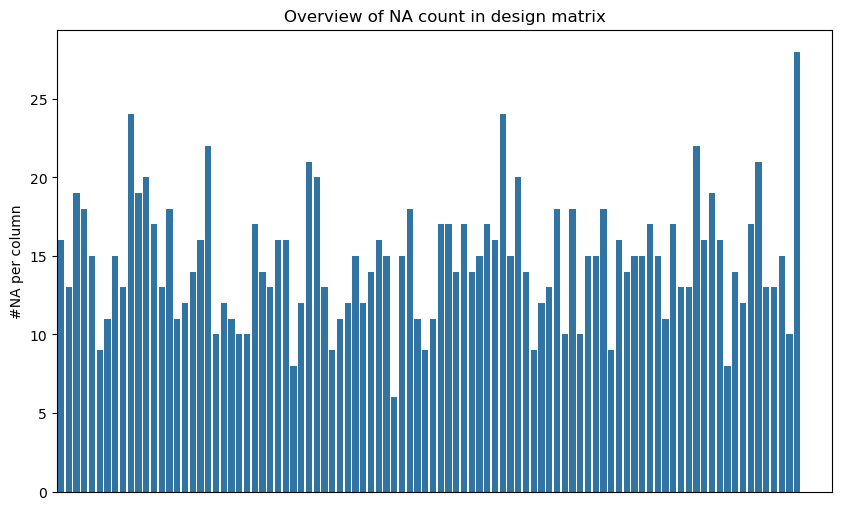

In [40]:
# what to do about the NA's?
nas = X.isna().sum(axis=0)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(
    
    x=nas.index,
    y= nas.values,
    color='tab:blue',

)
plt.title('Overview of NA count in design matrix')
plt.xticks([])
plt.ylabel('#NA per column')

For any given column 10-25% of data is missing. In total, ~14% of data is missing. In this case, the choice of how to fill NA's will have a significant impact on the models performance. The first, simplest choice is to impute the columns mean or a majority label.

## Use column mean or majority for NA

In [41]:
# look into the categorical attributes
cat_cols = [col for col in X.columns if 'C' in col]
for col in cat_cols:
    print(X[col].value_counts())
    print('-'*10)

C_1
 J    23
 G    18
 H    12
 I    11
 K     8
Name: count, dtype: int64
----------
C_2
 H    100
Name: count, dtype: int64
----------
C_3
 J    26
 G    21
 K    21
 I    16
 H    16
Name: count, dtype: int64
----------
C_4
 K    24
 G    24
 J    20
 I    20
 H    12
Name: count, dtype: int64
----------
C_5
 K    24
 I    24
 J    19
 H    17
 G    16
Name: count, dtype: int64
----------


C_1 is the only one missing lables. C_2 is redundant as it only contains a single lable (H), so should not be included in the model.

In [42]:
# fill missing data

X_mean = X.copy()
for col in X_mean.columns:
    if 'x' in col: 
        # impute mean for continuous
        X_mean[col] = X_mean[col].replace(np.nan, X_mean[col].mean())
    else:
        # impute majority group for categorical
        X_mean[col] = X_mean[col].replace(np.nan, X_mean[col].value_counts().index[0]) 

## Scale and encode attribute data

In [43]:
# drop C_2 from cat_cols
cat_cols.remove('C_2')

In [44]:
X_cont = X_mean.loc[:,[col for col in X_mean.columns if 'x' in col]]
X_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_cont), columns=X_cont.columns)
X_scaled = pd.concat([X_cont,pd.get_dummies(X_mean[cat_cols])], axis=1)

In [45]:
X_scaled

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,C_4_ G,C_4_ H,C_4_ I,C_4_ J,C_4_ K,C_5_ G,C_5_ H,C_5_ I,C_5_ J,C_5_ K
0,1.208626e-15,0.000000,2.013601,1.090246,5.439675e-01,1.238584,0.384261,0.319772,0.332268,6.545004e-16,...,False,False,False,False,True,False,False,False,True,False
1,6.983175e-01,-0.144005,0.522778,0.078762,1.958793e+00,1.949235,-0.445017,0.000000,0.913556,4.184132e-01,...,True,False,False,False,False,True,False,False,False,False
2,-1.902184e+00,-0.074197,0.130797,0.134436,3.885536e-02,0.350106,0.524269,-0.327886,0.938738,1.064744e+00,...,False,True,False,False,False,True,False,False,False,False
3,2.634566e+00,-0.604329,0.090897,1.086510,1.923120e+00,-1.015659,-1.976761,1.106461,-1.127875,-7.314475e-01,...,False,False,False,False,True,True,False,False,False,False
4,4.245698e-01,0.000000,2.145321,0.616044,3.625686e-01,-0.765803,-0.595190,0.000000,-0.955925,2.822050e-01,...,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.275262e-01,1.171230,0.644411,-0.627415,1.374446e-15,-0.329834,0.000000,0.153868,0.000000,1.426949e+00,...,True,False,False,False,False,True,False,False,False,False
96,-1.124048e+00,-0.946810,-0.760087,-0.986996,-8.727656e-01,-0.074669,-1.275224,-2.475271,-0.392276,-1.029843e+00,...,False,False,True,False,False,False,False,False,False,True
97,1.023399e+00,-0.577438,-0.410512,0.353594,-8.052793e-01,0.135594,0.192402,2.093797,0.879410,1.365966e+00,...,False,False,False,False,True,False,False,False,True,False
98,-1.279526e+00,-0.558466,0.000000,-0.526967,-4.718385e-01,-1.310155,0.186591,-0.928186,0.000000,-1.890162e+00,...,False,True,False,False,False,True,False,False,False,False


# General considerations:

- We should remember that we do the imputations within each fold of the cross-validation.
- We could consider algorithms like decision trees (Random Forest lecture 7/3 or gradient boosting) since it can split the nodes to handle these NaNs and hereby we don't need to impute.
- We should include the terms MCAR, MAR, and NMAR. For example, that NMAR is difficult for us to determine whether this is present due to the lack of domain knowledge in the dataset etc. (https://stefvanbuuren.name/fimd/sec-MCAR.html) (https://medium.com/analytics-vidhya/different-types-of-missing-data-59c87c046bf7). This also makes it difficult for us to choose the correct imputation. It's also a bit difficult to check for MAR since we have 100 variables and we don't know what the different variables are (like the actual meaning of the given variable). In other words, we don't know which variables that are logically related to each other such as function of the lungs and smoking habits. 

# Use KNN imputation for NaN

In [46]:
X_knn = X.copy()
# using same preprocessing as before in order to maintain same recipe (continous variables)
X_knn_cont = X_knn.loc[:,[col for col in X_knn.columns if 'x' in col]]
X_knn_cont = pd.DataFrame(preprocessing.StandardScaler().fit_transform(X_knn_cont), columns=X_knn_cont.columns)

# performing one-hot encoding before KNN imputation in order to avoid the model to assume some sort of ordinal relationship
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# one hot encoding
onehot_data = onehot.fit_transform(X_knn[cat_cols])
onehot_columns = onehot.get_feature_names_out()

# new df
onehot_cat_df = pd.DataFrame(onehot_data, columns=onehot_columns)

X_knn_scaled = pd.concat([X_knn_cont,onehot_cat_df], axis=1)
# dropping the nan column
X_knn_scaled = X_knn_scaled.drop(columns={'C_1_nan'})

c:\Users\oscar\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [52]:
# KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Apply to dataset
imputed_data = knn_imputer.fit_transform(X_knn_scaled)

imputed_df = pd.DataFrame(imputed_data, columns=X_knn_scaled.columns)

In [53]:
imputed_df

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,C_4_ G,C_4_ H,C_4_ I,C_4_ J,C_4_ K,C_5_ G,C_5_ H,C_5_ I,C_5_ J,C_5_ K
0,-0.173097,0.122542,1.812241,0.987260,0.501513,1.181534,0.362511,0.294815,0.309919,0.827225,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.640019,-0.134319,0.470501,0.071322,1.805918,1.859452,-0.419828,1.056915,0.852108,0.364764,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.743380,-0.069207,0.117717,0.121737,0.035823,0.333980,0.494595,-0.302296,0.875596,0.928222,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2.414620,-0.563680,0.081807,0.983877,1.773029,-0.968877,-1.864873,1.020107,-1.052012,-0.637661,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.389125,-0.043864,1.930789,0.557851,0.334272,-0.730530,-0.561501,-0.130242,-0.891628,0.246021,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.208531,1.092451,0.579970,-0.568148,0.468801,-0.314641,0.215397,0.141859,0.219194,1.243985,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96,-1.030207,-0.883125,-0.684079,-0.893763,-0.804650,-0.071229,-1.203043,-2.282087,-0.365891,-0.897796,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,0.937960,-0.538598,-0.369461,0.320193,-0.742431,0.129349,0.181511,1.930385,0.820259,1.190822,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
98,-1.172705,-0.520903,-1.120792,-0.477189,-0.435014,-1.249808,0.176029,-0.855746,-0.947978,-1.647805,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
